In [158]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.linear_model import LinearRegression , Ridge
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error , mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

Explore Data

In [159]:
df = pd.read_csv('BIKE DETAILS.csv')
df.head()

,name,selling_price,year,seller_type,owner,km_driven,ex_showroom_price
0,Royal Enfield Classic 350,175000,2019,Individual,1st owner,350,NaN
1,Honda Dio,45000,2017,Individual,1st owner,5650,NaN
2,Royal Enfield Classic Gunmetal Grey,150000,2018,Individual,1st owner,12000,148114.0
3,Yamaha Fazer FI V 2.0 [2016-2018],65000,2015,Individual,1st owner,23000,89643.0
4,Yamaha SZ [2013-2014],20000,2011,Individual,2nd owner,21000,NaN


In [160]:
df.shape

(1061, 7)

In [161]:
print('Missing values :')
df.isnull().sum()

Missing values :


name                   0
selling_price          0
year                   0
seller_type            0
owner                  0
km_driven              0
ex_showroom_price    435
dtype: int64

In [162]:
df.describe()

,selling_price,year,km_driven,ex_showroom_price
count,1061.000000,1061.000000,1061.000000,6.260000e+02
mean,59638.151744,2013.867107,34359.833176,8.795871e+04
std,56304.291973,4.301191,51623.152702,7.749659e+04
min,5000.000000,1988.000000,350.000000,3.049000e+04
25%,28000.000000,2011.000000,13500.000000,5.485200e+04
50%,45000.000000,2015.000000,25000.000000,7.275250e+04
75%,70000.000000,2017.000000,43000.000000,8.703150e+04
max,760000.000000,2020.000000,880000.000000,1.278000e+06


In [163]:
q = df['selling_price'].quantile(0.975)
df = df[df['selling_price'] < q]

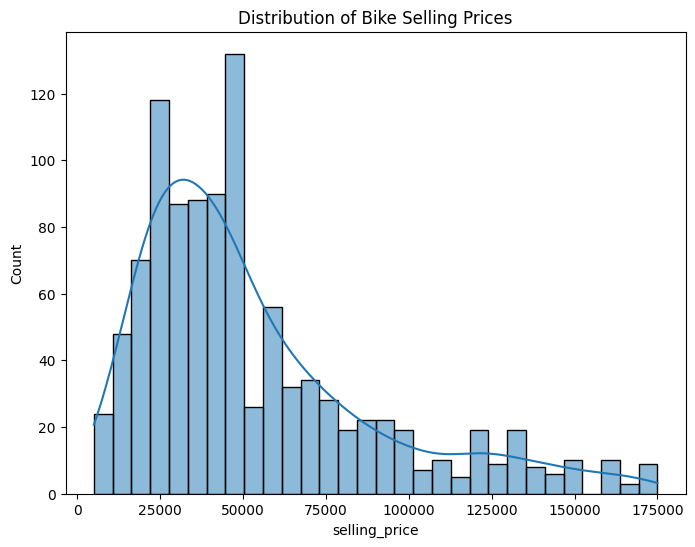

In [164]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='selling_price', bins=30, kde=True)
plt.title('Distribution of Bike Selling Prices')
plt.show()

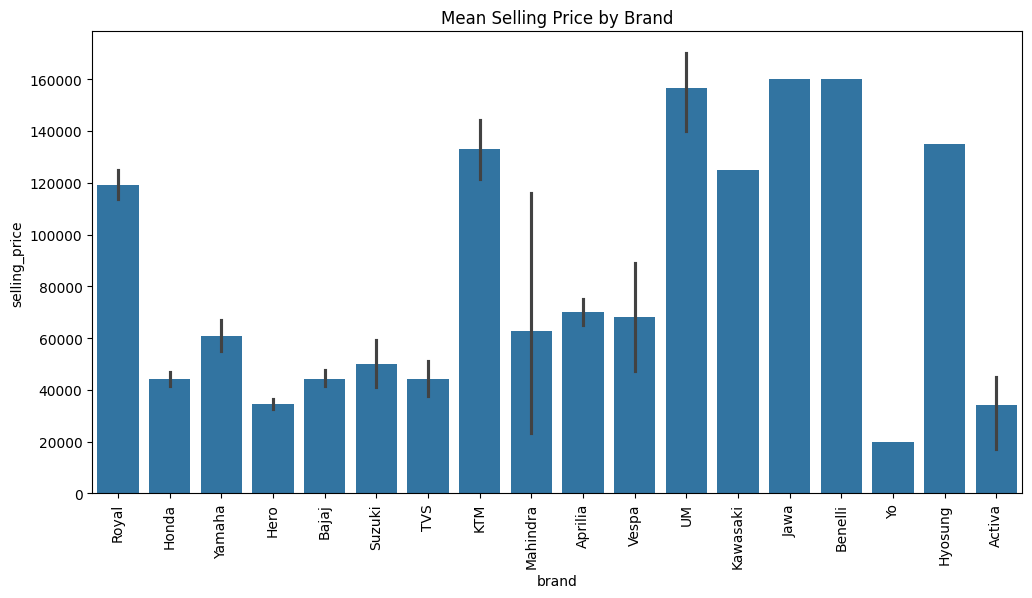

In [165]:
df['brand'] = df['name'].apply(lambda x: x.split()[0])

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='brand', y='selling_price', estimator='mean')
plt.xticks(rotation=90)
plt.title('Mean Selling Price by Brand')
plt.show()

In [166]:
df['ex_showroom_price'] = df['ex_showroom_price'].fillna(df['ex_showroom_price'].mean())

In [167]:
df.describe()

,selling_price,year,km_driven,ex_showroom_price
count,1030.000000,1030.000000,1030.000000,1030.000000
mean,53346.678641,2013.761165,35181.764078,80178.643208
std,36037.408053,4.295821,52159.074675,29142.665975
min,5000.000000,1988.000000,350.000000,30490.000000
25%,27000.000000,2011.000000,14500.000000,64017.750000
50%,42000.000000,2015.000000,25000.000000,80178.643208
75%,68750.000000,2017.000000,44000.000000,80178.643208
max,175000.000000,2020.000000,880000.000000,345000.000000


In [168]:
print('Missing values :')
df.isnull().sum()

Missing values :


name                 0
selling_price        0
year                 0
seller_type          0
owner                0
km_driven            0
ex_showroom_price    0
brand                0
dtype: int64

In [169]:
df['Age'] = 2020 - df['year']

In [170]:
df['name'].unique()

array(['Royal Enfield Classic 350', 'Honda Dio',
       'Royal Enfield Classic Gunmetal Grey',
       'Yamaha Fazer FI V 2.0 [2016-2018]', 'Yamaha SZ [2013-2014]',
       'Honda CB Twister', 'Honda CB Hornet 160R',
       'Hero Honda CBZ extreme', 'Bajaj Discover 125', 'Yamaha FZ16',
       'Honda Navi', 'Bajaj Avenger Street 220',
       'Suzuki Access 125 [2007-2016]', 'Hero Honda Glamour',
       'Yamaha YZF R15 S', 'Yamaha FZ25', 'Hero Passion Pro 110',
       'Honda Navi [2016-2017]', 'Honda Activa i',
       'Royal Enfield Thunderbird 350', 'Honda Dream Yuga',
       'TVS Apache RTR 160 4V', 'Yamaha Fazer [2009-2016]',
       'Hero Honda Splendor NXG', 'Hero Glamour 125',
       'Yamaha FZ S [2012-2016]', 'Hero Xtreme Sports', 'Honda X-Blade',
       'Honda CB Shine SP', 'Honda Activa 5G', 'Honda CBR-250R',
       'Hero Honda Passion PRO [2012]', 'Bajaj Dominar 400',
       'Hero Glamour FI', 'KTM 390 Duke', 'Hero Passion XPro',
       'Yamaha FZ S V 2.0', 'Hero Achiever 150', 'Y

In [171]:
# Step 1: Extract Brand
brands = ['Royal Enfield', 'Hero Honda', 'Honda', 'Yamaha', 'Bajaj', 'Suzuki', 'TVS', 
              'KTM', 'Mahindra', 'UM', 'Jawa', 'Aprilia', 'Vespa', 'Kawasaki', 
              'Harley-Davidson', 'Benelli', 'Yo', 'Hyosung', 'BMW']

def extract_brand(text):
    for brand in sorted(brands, key=len, reverse=True): 
        if text.startswith(brand):
            return brand
    return 'Other'

df['brand'] = df['name'].apply(extract_brand)

# Step 2: Extract Engine Capacity 
def extract_cc(text):
    numbers = re.findall(r'\d+', text)
    for num in numbers:
        if len(num) == 3:  # Prioritize 3-digit numbers
            return int(num)
    for num in numbers:
        if len(num) == 2:  # Convert 2-digit numbers (e.g., FZ25 → 250cc)
            return int(num) * 10
    return None  # If no numbers found

df['engine_cc'] = df['name'].apply(extract_cc)

# Step 3: Extract Model Year
def extract_year(text):
    year_match = re.search(r'\[(\d{4})-?(\d{4})?\]', text)
    if year_match:
        return int(year_match.group(2) or year_match.group(1))
    return None

df['year'] = df['name'].apply(extract_year)

# Step 4: Extract Model Family
def extract_model_family(text):
    # Remove brand
    text = re.sub(df['brand'][0], '', text, flags=re.IGNORECASE).strip()
    # Remove engine CC
    text = re.sub(r'\d+', '', text).strip()
    # Remove year brackets
    text = re.sub(r'\[.*\]', '', text).strip()
    # Take first meaningful words
    return ' '.join(text.split()[:3]).strip()

df['model_family'] = df.apply(lambda row: extract_model_family(row['name']), axis=1)

# Step 5: Flag Key Features
features = {
    'FI': r'\bFI\b',
    'ABS': r'\bABS\b',
    'Fuel Injection': r'\bFuel Injection\b',
    '4V': r'\b4V\b'
}

for feature, pattern in features.items():
    df[f'has_{feature.lower()}'] = df['name'].str.contains(pattern, regex=True).astype(int)

# Step 6: Handle Inconsistencies
def clean_model_name(text):
    # Standardize common variations
    replacements = {
        r'FZ(\d+)': r'FZ \1',
        r'NS(\d+)': r'NS \1',
        r'(\bPro\b)': r'Pro',
        r'\s+': ' '
    }
    for pattern, replacement in replacements.items():
        text = re.sub(pattern, replacement, text)
    return text.strip()

df['name'] = df['name'].apply(clean_model_name)

# Step 7: Final Encoding
# One-hot encode categorical features
df = pd.get_dummies(df, columns=['brand', 'model_family'], prefix_sep='_')

# Drop original column
df = df.drop('name', axis=1)

In [172]:
df.head()

,selling_price,year,seller_type,owner,km_driven,ex_showroom_price,Age,engine_cc,has_fi,has_abs,...,model_family_Yamaha Rx,model_family_Yamaha SZ,model_family_Yamaha SZ RR,model_family_Yamaha SZ X,model_family_Yamaha SZ-S,model_family_Yamaha Saluto,model_family_Yamaha Saluto RX,model_family_Yamaha YBR,model_family_Yamaha YZF R,model_family_Yo Style
0,175000,NaN,Individual,1st owner,350,80178.643208,1,350.0,0,0,...,False,False,False,False,False,False,False,False,False,False
1,45000,NaN,Individual,1st owner,5650,80178.643208,3,NaN,0,0,...,False,False,False,False,False,False,False,False,False,False
2,150000,NaN,Individual,1st owner,12000,148114.000000,2,NaN,0,0,...,False,False,False,False,False,False,False,False,False,False
3,65000,2018.0,Individual,1st owner,23000,89643.000000,5,NaN,1,0,...,False,False,False,False,False,False,False,False,False,False
4,20000,2014.0,Individual,2nd owner,21000,80178.643208,9,NaN,0,0,...,False,True,False,False,False,False,False,False,False,False


In [173]:
df.isna().sum()

selling_price                      0
year                             911
seller_type                        0
owner                              0
km_driven                          0
                                ... 
model_family_Yamaha Saluto         0
model_family_Yamaha Saluto RX      0
model_family_Yamaha YBR            0
model_family_Yamaha YZF R          0
model_family_Yo Style              0
Length: 215, dtype: int64

In [174]:
for U in df:
    print(f'column: {U}\n')
    print(df[U].unique())
    print('---' *20)

column: selling_price

[175000  45000 150000  65000  20000  18000  78500  30000  50000  35000
  28000  80000  25000  40000 120000  15000  26000  32000 110000  42000
  21000  55000  38000  43000  62000  60000  90000 125000  85000  29900
  70000  48000  34000 165000  29500  95000   7500 160000 140000  22000
  22989  24999  75000  17500  57000  83900 135000 130000  54786  72000
 100000 138000 170000 123000  23000  41000  47999  36999  12000  27000
  10000  56000  58000  87000 145000   9000  14000  17000  54000  98000
  37000 162000  69000  26500  78000   8000  39000  36000  16000  83299
  14700  19000  14900  24000  24700  52000  47000 105000 115000   5000
  86000  28700   6000  23500  68000  20100  14500  46000  30900  89999
  17600  51000  74000  85009  16600  99000  77000  76000 119000  59000
  25500 111000  31000]
------------------------------------------------------------
column: year

[  nan 2018. 2014. 2016. 2017. 2012. 2011. 2010. 2015. 2005. 2006.]
------------------------------

Drop duplicated rows

In [175]:
df.duplicated().sum()

6

In [176]:
df.drop_duplicates(inplace=True)

In [177]:
df.shape

(1024, 215)

In [178]:
for U in df:
    print(f'column: {U}\n')
    print(df[U].unique())
    print('---' *20)

column: selling_price

[175000  45000 150000  65000  20000  18000  78500  30000  50000  35000
  28000  80000  25000  40000 120000  15000  26000  32000 110000  42000
  21000  55000  38000  43000  62000  60000  90000 125000  85000  29900
  70000  48000  34000 165000  29500  95000   7500 160000 140000  22000
  22989  24999  75000  17500  57000  83900 135000 130000  54786  72000
 100000 138000 170000 123000  23000  41000  47999  36999  12000  27000
  10000  56000  58000  87000 145000   9000  14000  17000  54000  98000
  37000 162000  69000  26500  78000   8000  39000  36000  16000  83299
  14700  19000  14900  24000  24700  52000  47000 105000 115000   5000
  86000  28700   6000  23500  68000  20100  14500  46000  30900  89999
  17600  51000  74000  85009  16600  99000  77000  76000 119000  59000
  25500 111000  31000]
------------------------------------------------------------
column: year

[  nan 2018. 2014. 2016. 2017. 2012. 2011. 2010. 2015. 2005. 2006.]
------------------------------

In [179]:
df.head()

,selling_price,year,seller_type,owner,km_driven,ex_showroom_price,Age,engine_cc,has_fi,has_abs,...,model_family_Yamaha Rx,model_family_Yamaha SZ,model_family_Yamaha SZ RR,model_family_Yamaha SZ X,model_family_Yamaha SZ-S,model_family_Yamaha Saluto,model_family_Yamaha Saluto RX,model_family_Yamaha YBR,model_family_Yamaha YZF R,model_family_Yo Style
0,175000,NaN,Individual,1st owner,350,80178.643208,1,350.0,0,0,...,False,False,False,False,False,False,False,False,False,False
1,45000,NaN,Individual,1st owner,5650,80178.643208,3,NaN,0,0,...,False,False,False,False,False,False,False,False,False,False
2,150000,NaN,Individual,1st owner,12000,148114.000000,2,NaN,0,0,...,False,False,False,False,False,False,False,False,False,False
3,65000,2018.0,Individual,1st owner,23000,89643.000000,5,NaN,1,0,...,False,False,False,False,False,False,False,False,False,False
4,20000,2014.0,Individual,2nd owner,21000,80178.643208,9,NaN,0,0,...,False,True,False,False,False,False,False,False,False,False


In [180]:
df.columns

Index(['selling_price', 'year', 'seller_type', 'owner', 'km_driven',
       'ex_showroom_price', 'Age', 'engine_cc', 'has_fi', 'has_abs',
       ...
       'model_family_Yamaha Rx', 'model_family_Yamaha SZ',
       'model_family_Yamaha SZ RR', 'model_family_Yamaha SZ X',
       'model_family_Yamaha SZ-S', 'model_family_Yamaha Saluto',
       'model_family_Yamaha Saluto RX', 'model_family_Yamaha YBR',
       'model_family_Yamaha YZF R', 'model_family_Yo Style'],
      dtype='object', length=215)

In [181]:
df.replace({'owner':{'1st owner':0,'2nd owner':1,'3rd owner':2, '4th owner':3}},inplace=True)

df.replace({'seller_type':{'Dealer':0,'Individual':1}},inplace=True)

C:\Users\besho\AppData\Local\Temp\ipykernel_13476\4167622102.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'owner':{'1st owner':0,'2nd owner':1,'3rd owner':2, '4th owner':3}},inplace=True)
C:\Users\besho\AppData\Local\Temp\ipykernel_13476\4167622102.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'seller_type':{'Dealer':0,'Individual':1}},inplace=True)


In [182]:
df.describe()

,selling_price,year,seller_type,owner,km_driven,ex_showroom_price,Age,engine_cc,has_fi,has_abs,has_fuel injection,has_4v
count,1024.000000,117.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,515.000000,1024.000000,1024.000000,1024.0,1024.000000
mean,53387.772461,2015.051282,0.994141,0.141602,35120.431641,80210.258025,6.235352,191.675728,0.004883,0.000977,0.0,0.009766
std,36072.951271,2.661495,0.076359,0.393580,52250.016622,29207.480599,4.300569,87.631955,0.069740,0.031250,0.0,0.098386
min,5000.000000,2005.000000,0.000000,0.000000,350.000000,30490.000000,0.000000,100.000000,0.000000,0.000000,0.0,0.000000
25%,27000.000000,2014.000000,1.000000,0.000000,14447.250000,63884.250000,3.000000,135.000000,0.000000,0.000000,0.0,0.000000
50%,42000.000000,2015.000000,1.000000,0.000000,25000.000000,80178.643208,5.000000,150.000000,0.000000,0.000000,0.0,0.000000
75%,68250.000000,2017.000000,1.000000,0.000000,44000.000000,80178.643208,9.000000,220.000000,0.000000,0.000000,0.0,0.000000
max,175000.000000,2018.000000,1.000000,3.000000,880000.000000,345000.000000,32.000000,500.000000,1.000000,1.000000,0.0,1.000000


In [183]:
mean_value = df['engine_cc'].mean()  
df['engine_cc'] = df['engine_cc'].fillna(mean_value)  

In [184]:
corr_matrix_np = np.corrcoef(df[df.select_dtypes(include=np.number).columns].to_numpy(), rowvar=False)

c:\Users\besho\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\besho\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


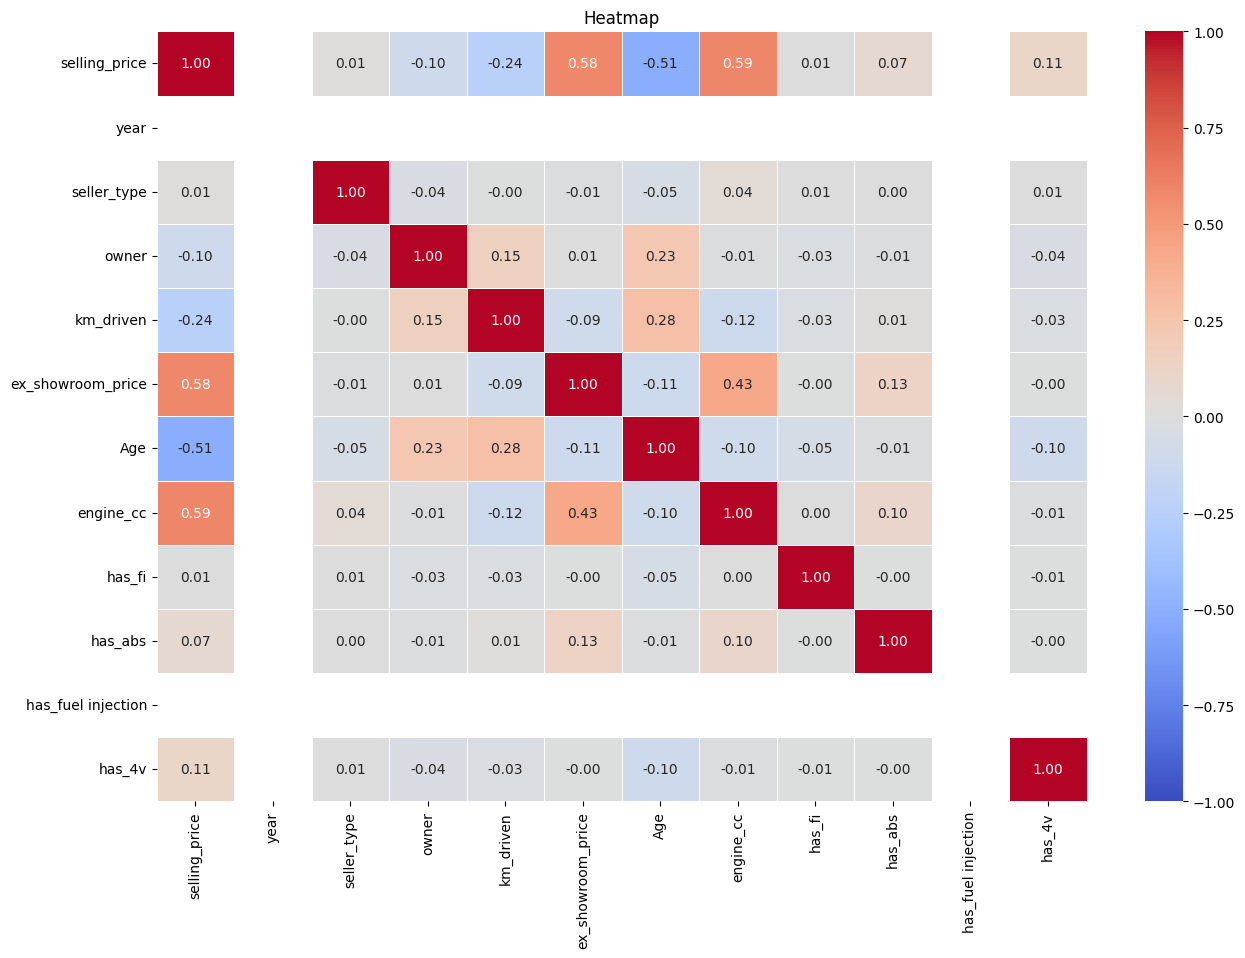

In [185]:
corr_matrix = pd.DataFrame(corr_matrix_np, 
                          index=df.select_dtypes(include=np.number).columns,
                          columns=df.select_dtypes(include=np.number).columns)

# Plot the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, 
            annot=True,
            cmap='coolwarm',
            fmt='.2f',
            linewidths=0.5,
            vmin=-1,  
            vmax=1)
plt.title('Heatmap')
plt.show()

Drop irrelevant columns

In [186]:
to_drop = ['owner','has_fi','has_abs','has_4v','seller_type','year','has_fuel injection']

In [187]:
df.drop(columns=to_drop,inplace = True)

In [188]:
corr_matrix_np = np.corrcoef(df[df.select_dtypes(include=np.number).columns].to_numpy(), rowvar=False)

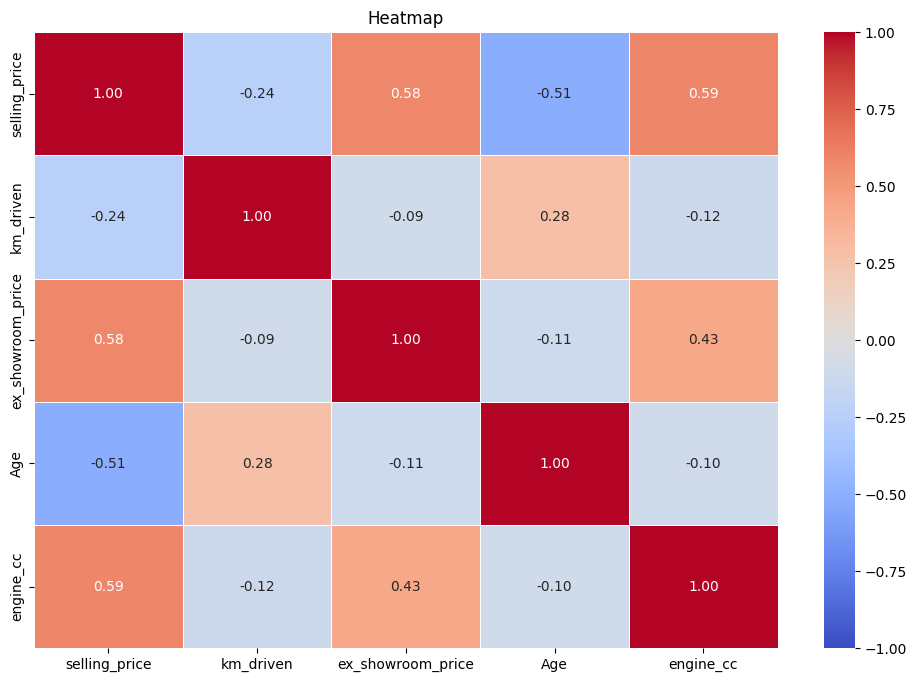

In [189]:
corr_matrix = pd.DataFrame(corr_matrix_np, 
                          index=df.select_dtypes(include=np.number).columns,
                          columns=df.select_dtypes(include=np.number).columns)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, 
            annot=True,
            cmap='coolwarm',
            fmt='.2f',
            linewidths=0.5,
            vmin=-1,  
            vmax=1)
plt.title('Heatmap')
plt.show()

In [190]:
X = df.drop(['selling_price'],axis=1)
y = df['selling_price']

In [191]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

In [192]:
lr = LinearRegression()

In [193]:
lr.fit(X_train,y_train)

LinearRegression()

In [194]:
pred = lr.predict(X_test)

In [195]:
# evaluate the LinearRegression model
print(f'R squared Error: {metrics.r2_score(y_test, pred):.2f}')
print(f'MAE: {mean_absolute_error(y_test, pred):.2f}')
print(f'MSE:  {mean_squared_error(y_test, pred):.2f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, pred)):.2f}')

R squared Error: 0.79
MAE: 11390.44
MSE:  276881480.47
RMSE: 16639.76


# GridSearch to choose best model and optimal hyperparameters tuning

In [196]:
# Define model parameters
model_params = {
    'xgboost': {
        'model': XGBRegressor(objective='reg:squarederror', random_state=42),
        'params': {
            'n_estimators': [50, 100, 150],
            'max_depth': [3, 4, 6],
            'learning_rate': [0.05, 0.1,.01],
            'subsample': [0.8, 0.9],
            'colsample_bytree': [0.8, 0.9],
            'gamma': [0, 0.1]
        }
    },
    'random_forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [50,100, 200],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
        }
    },
    'svr': {
        'model': SVR(),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['rbf', 'linear'],
            'epsilon': [0.01, 0.1]
        }
    },
    'ridge': {
        'model': Ridge(random_state=42),
        'params': {
            'alpha': [0.1, 1, 10, 100],
            'solver': ['svd', 'sag']
        }
    }
}


In [197]:
# Feature scaling for SVR and Ridge
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [198]:
# Perform grid search for all models
results = []
for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], 
                       mp['params'], 
                       cv=5,
                       scoring='neg_mean_squared_error',
                       n_jobs=-1,
                       verbose=1,
                       refit=True)  
    
    # For tree-based models used original data 
    if model_name in ['random_forest', 'xgboost']:
        X_train_final = X_train
        X_test_final = X_test
    else:
        X_train_final = X_train_scaled
        X_test_final = X_test_scaled
    
    clf.fit(X_train_final, y_train)
    
      # Store results
    results.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'test_rmse': np.sqrt(-clf.score(X_test_final, y_test)),
        'r2_score': r2_score(y_test, clf.predict(X_test_final))
    })

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [199]:
results_df = pd.DataFrame(results, columns=['model', 'best_score', 'best_params', 'test_rmse', 'r2_score'])
print("\nModels Performance:")
results_df


Models Performance:


,model,best_score,best_params,test_rmse,r2_score
0,xgboost,-1.772813e+08,"{'colsample_bytree': 0.8, 'gamma': 0, 'learnin...",10738.279548,0.911718
1,random_forest,-1.821686e+08,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",11291.179737,0.902392
2,svr,-8.845895e+08,"{'C': 10, 'epsilon': 0.01, 'kernel': 'linear'}",27764.495797,0.409820
3,ridge,-3.161463e+08,"{'alpha': 100, 'solver': 'sag'}",15726.818287,0.810641


In [200]:
# Access the best estimator for the best model 
best_model_idx = results_df['test_rmse'].idxmin()  # Index of model with lowest RMSE
best_model_name = results_df.loc[best_model_idx, 'model']
print(f"\nBest Model: {best_model_name}")


Best Model: xgboost


In [201]:
# Re-run GridSearchCV for the best model to get its best_estimator_
best_mp = model_params[best_model_name]
clf = GridSearchCV(best_mp['model'], 
                   best_mp['params'], 
                   cv=5,
                   scoring='neg_mean_squared_error',
                   n_jobs=-1,
                   verbose=1,
                   refit=True)
if best_model_name in ['random_forest', 'xgboost']:
    clf.fit(X_train_final, y_train)
else:
    clf.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


In [202]:
print(f"Best Estimator for {best_model_name}:\n")
clf.best_estimator_

Best Estimator for xgboost:



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

# Best Hyperparameters for Xgboost : 

In [203]:
clf.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 6,
 'n_estimators': 150,
 'subsample': 0.8}

# Evaluation of best model (Xgboost) : 

In [204]:
y_pred = clf.predict(X_test_final)

In [205]:
mae = mean_absolute_error(y_test,y_pred)
print(f'MAE = {mae:.3f}')

MAE = 7962.268


In [206]:
print(f"RMSE = {np.sqrt(mean_squared_error(y_test,y_pred)):.2f}")

RMSE = 10738.28


In [207]:
r2 = r2_score(y_test,y_pred)
print(f'r2 = {r2*100:.2f}')

r2 = 91.17


# Actual vs Predicted plot

Text(0.5, 1.0, 'Actual vs Predicted Values')

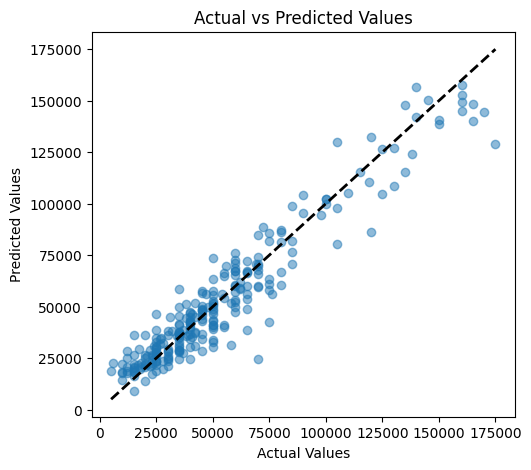

In [208]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')

# Done